In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../src/metrics_results.csv')

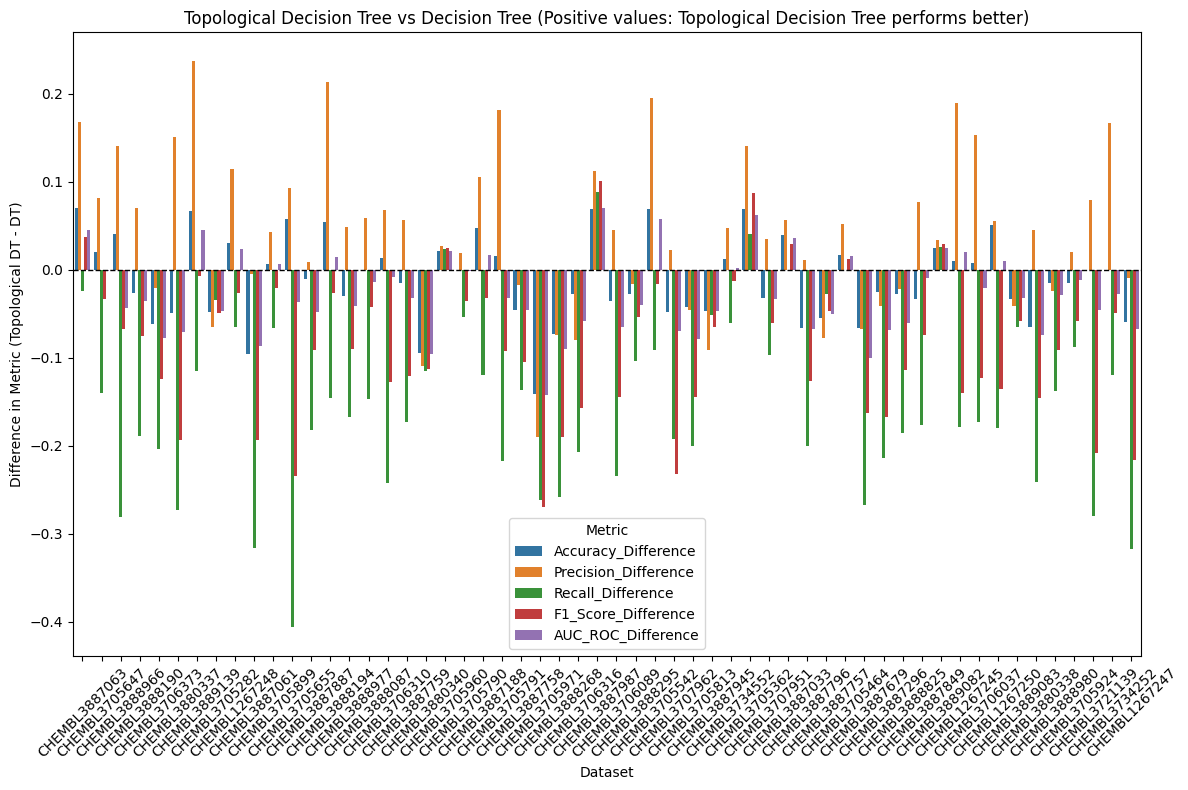

In [5]:
# Calculate the differences between the metrics of topological decision tree and decision tree
df['Accuracy_Difference'] = df['Topological_Decision_Tree_Accuracy'] - df['Decision_Tree_Accuracy']
df['Precision_Difference'] = df['Topological_Decision_Tree_Precision'] - df['Decision_Tree_Precision']
df['Recall_Difference'] = df['Topological_Decision_Tree_Recall'] - df['Decision_Tree_Recall']
df['F1_Score_Difference'] = df['Topological_Decision_Tree_F1_Score'] - df['Decision_Tree_F1_Score']
df['AUC_ROC_Difference'] = df['Topological_Decision_Tree_AUC_ROC'] - df['Decision_Tree_AUC_ROC']

# Combine differences into a DataFrame for easier plotting
differences_df = df[['Dataset', 'Accuracy_Difference', 'Precision_Difference', 'Recall_Difference', 'F1_Score_Difference', 'AUC_ROC_Difference']]

# Melt the DataFrame to long format for plotting
differences_long_df = differences_df.melt(id_vars='Dataset', var_name='Metric', value_name='Difference')

# Plotting the differences using bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Dataset', y='Difference', hue='Metric', data=differences_long_df)

# Customize plot
plt.xticks(rotation=45)
plt.title("Topological Decision Tree vs Decision Tree (Positive values: Topological Decision Tree performs better)")
plt.ylabel("Difference in Metric (Topological DT - DT)")
plt.xlabel("Dataset")
plt.legend(title='Metric')

# Add horizontal line at y=0 for reference
plt.axhline(0, color='black', linewidth=1, linestyle='--')


plt.tight_layout()
plt.show()